### Bayesian Analysis of Voting Trends

Outstanding Development Steps:

1. Bayesian Model using cultural regions, urban/rural split and the interaction (create diagram)
2. Build a full regression on all the indicators.

In [2]:
# Imports
import pandas as pd
import numpy as np
import pymc3 as pm
from pymc3 import *
import theano
from theano import tensor as tt
import arviz as az
from pandas.plotting import scatter_matrix
floatX = theano.config.floatX
import seaborn as sns

# Ignore Pandas warnings
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/theano/configdefaults.py:696: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn(
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# Constants
dataPath = '/Users/dylansmith/Documents/ActiveProjects/PoliticalAnalysis/data/processed/'
analysis_cols = ['FIPS','DESCRIPTION','REGION', 'candidatevotes','totalvotes']

### Data Merging

In [162]:
df_vote = pd.read_csv(dataPath + 'voting.tsv.gz',
                compression = 'gzip',
                sep='\t',
                encoding='utf-8',
                dtype = {'FIPS':np.str, 'totalvotes': np.int})
df_vote.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes
0,1976,AZ,04000,US Senate,statewide,False,Sam Steiger,republican,321236.0,741210
1,1976,AZ,04000,US Senate,statewide,False,Wm. Mathews Feighan,independent,1565.0,741210
2,1976,AZ,04000,US Senate,statewide,False,Dennis DeConcini,democrat,400334.0,741210
3,1976,AZ,04000,US Senate,statewide,False,Allan Norwitz,libertarian,7310.0,741210
4,1976,AZ,04000,US Senate,statewide,False,Bob Field,independent,10765.0,741210


In [163]:
# Get the Cultural Data
df_cult = pd.read_csv(dataPath + 'culture.tsv.gz',
                    compression = 'gzip',
                    sep='\t',
                    dtype = {'FIPS':np.str, 'REGION': np.int})
df_cult.head()

,FIPS,State,REGION,DESCRIPTION,year_join,RuralUrbanContinuumCode,UrbanInfluenceCode,Metro,Nonmetro,Micropolitan
0,01001,AL,1,DEEP SOUTH,2000,2.0,2.0,1.0,0.0,0.0
1,01003,AL,1,DEEP SOUTH,2000,4.0,5.0,0.0,1.0,1.0
2,01005,AL,1,DEEP SOUTH,2000,6.0,6.0,0.0,1.0,0.0
3,01007,AL,1,DEEP SOUTH,2000,1.0,1.0,1.0,0.0,0.0
4,01009,AL,11,GREATER APPALACHIA,2000,1.0,1.0,1.0,0.0,0.0


In [164]:
# Get the Cultural Data
df_cult = pd.read_csv(dataPath + 'culture.tsv.gz',
                    compression = 'gzip',
                    sep='\t',
                    dtype = {'FIPS':np.str, 'REGION': np.int})

df_vote['year_join'] = df_vote['year'] // 10 * 10
df_vote['year_join'] = df_vote['year_join'].replace(2020, 2010)
# Bring together the dataframes and filter out AK & HI
df_agg = df_vote[(~df_vote['state_po'].isin(['AK','HI'])) & (df_vote['year'] >= 2000)]\
                                                                    .merge(df_cult, on = ['FIPS','year_join'], how = 'left')
df_agg.drop('State', inplace = True, axis = 1)
df_agg.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,year_join,REGION,DESCRIPTION,RuralUrbanContinuumCode,UrbanInfluenceCode,Metro,Nonmetro,Micropolitan
0,2000,AZ,04000,US Senate,statewide,False,William Toel,independent,109230.0,1397076,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,AZ,04000,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,AZ,04000,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,AZ,04000,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,CA,06000,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# Get the Cultural Data
df_gdp = pd.read_csv(dataPath + 'gdp.tsv.gz',
                    compression = 'gzip',
                    sep='\t',
                    dtype = {'FIPS':np.str})
df_gdp.rename({'YR':'year'}, axis = 1, inplace = True)

df_agg = df_agg.merge(df_gdp, on = ['FIPS','year'], how = 'left')
df_agg.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,...,USD_Nondurable goods manufacturing,USD_Private industries,"USD_Professional, scientific, and technical services",USD_Real estate and rental and leasing,USD_Retail trade,USD_Trade,USD_Transportation and utilities,USD_Transportation and warehousing,USD_Utilities,USD_Wholesale trade
0,2000,AZ,04000,US Senate,statewide,False,William Toel,independent,109230.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,AZ,04000,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,AZ,04000,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,AZ,04000,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,CA,06000,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# Get the Employment Data
df_employ = pd.read_csv(dataPath + 'employment.tsv.gz',
                    compression = 'gzip',
                    sep='\t',
                    dtype = {'FIPS':np.str})
df_employ.rename({'YR':'year'}, axis = 1, inplace = True)
df_agg = df_agg.merge(df_employ, on = ['FIPS','year'], how = 'left')
df_agg.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,...,WAGE AND SALARY EMPLOYMENT,WHOLESALE TRADE,State,Unemployment_Rate,Curr_MedHHInc,Curr_PerCapitaInc,Curr_PovertyUnder18Pct,Curr_PovertyAllAgesPct,Curr_Deep_Pov_All,Curr_Deep_Pov_Children
0,2000,AZ,04000,US Senate,statewide,False,William Toel,independent,109230.0,1397076,...,0.832424,0.043542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,AZ,04000,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,...,0.832424,0.043542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,AZ,04000,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,...,0.832424,0.043542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,AZ,04000,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,...,0.832424,0.043542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,CA,06000,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,...,0.812422,0.046937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
# Get the Demographic Data
df_demo = pd.read_csv(dataPath + 'demographics.tsv.gz',
                    compression = 'gzip',
                    sep='\t',
                    dtype = {'FIPS':np.str})
df_demo.rename({'YEAR':'year'}, axis = 1, inplace = True)

df_agg = df_agg.merge(df_demo, on = ['FIPS','year'], how = 'left')
df_agg.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,...,WA_FEMALE_50_to_64,WA_FEMALE_65+,WA_FEMALE_80_to_84,WA_FEMALE_Total_Population,WA_MALE_18_to_29,WA_MALE_30_to_49,WA_MALE_50_to_64,WA_MALE_65+,WA_MALE_80_to_84,WA_MALE_Total_Population
0,2000,AZ,04000,US Senate,statewide,False,William Toel,independent,109230.0,1397076,...,5.843346,5.306117,0.930111,31.790678,4.596379,9.304823,5.406820,4.341420,0.676022,30.846883
1,2000,AZ,04000,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,...,5.843346,5.306117,0.930111,31.790678,4.596379,9.304823,5.406820,4.341420,0.676022,30.846883
2,2000,AZ,04000,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,...,5.843346,5.306117,0.930111,31.790678,4.596379,9.304823,5.406820,4.341420,0.676022,30.846883
3,2000,AZ,04000,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,...,5.843346,5.306117,0.930111,31.790678,4.596379,9.304823,5.406820,4.341420,0.676022,30.846883
4,2000,CA,06000,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,...,4.176411,3.592577,0.690737,22.896282,3.112681,7.518715,4.087429,2.677086,0.449619,22.365768


In [168]:
# Get the Education Data
df_edu = pd.read_csv(dataPath + 'education.tsv.gz',
                    compression = 'gzip',
                    sep='\t',
                    dtype = {'FIPS':np.str})

df_agg = df_agg.merge(df_edu, on = ['FIPS','year_join'], how = 'left')
df_agg.drop('year_join', inplace = True, axis = 1)
df_agg.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,...,WA_MALE_30_to_49,WA_MALE_50_to_64,WA_MALE_65+,WA_MALE_80_to_84,WA_MALE_Total_Population,State_y,PCT_LESS_HS,PCT_HS,PCT_SOME_BA,PCT_EQ_MORE_BA
0,2000,AZ,04000,US Senate,statewide,False,William Toel,independent,109230.0,1397076,...,9.304823,5.406820,4.341420,0.676022,30.846883,AZ,19.0,24.3,33.1,23.5
1,2000,AZ,04000,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,...,9.304823,5.406820,4.341420,0.676022,30.846883,AZ,19.0,24.3,33.1,23.5
2,2000,AZ,04000,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,...,9.304823,5.406820,4.341420,0.676022,30.846883,AZ,19.0,24.3,33.1,23.5
3,2000,AZ,04000,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,...,9.304823,5.406820,4.341420,0.676022,30.846883,AZ,19.0,24.3,33.1,23.5
4,2000,CA,06000,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,...,7.518715,4.087429,2.677086,0.449619,22.365768,CA,23.2,20.1,30.0,26.6


In [169]:
# Get the Education Data
df_vdem = pd.read_csv(dataPath + 'vdem_political_parties.tsv.gz',
                    compression = 'gzip',
                    sep='\t')

df_agg = df_agg.merge(df_vdem, on = ['party','year'], how = 'left')
df_agg.head()

,year,state_po,FIPS,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,...,leader_controls_party_policy,people_over_elite_decisions,populism_type,populist_values_type,favors_populist_rhetoric,importance_populism,authoritarian_position,importance_libertarian,social_conservative_values,importance_social_values
0,2000,AZ,04000,US Senate,statewide,False,William Toel,independent,109230.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,AZ,04000,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,AZ,04000,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,AZ,04000,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,CA,06000,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
df_agg = df_agg.groupby('FIPS').bfill().ffill()

In [172]:
df_agg

,year,state_po,office,DISTRICT,special,candidate,party,candidatevotes,totalvotes,REGION,...,leader_controls_party_policy,people_over_elite_decisions,populism_type,populist_values_type,favors_populist_rhetoric,importance_populism,authoritarian_position,importance_libertarian,social_conservative_values,importance_social_values
0,2000,AZ,US Senate,statewide,False,William Toel,independent,109230.0,1397076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,AZ,US Senate,statewide,False,Vance Hansen,green,108926.0,1397076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,AZ,US Senate,statewide,False,Jon Kyl,republican,1108196.0,1397076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,AZ,US Senate,statewide,False,Barry J. Hess II,libertarian,70724.0,1397076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,CA,US Senate,statewide,False,"Jose Luis ""Joe"" Camahort",reform,96552.0,10623608,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170723,2020,WY,President,statewide,False,Donald J. Trump,republican,3107.0,3542,9.0,...,NaN,NaN,strongly_populist,populist_conservative,7.825,8.125,NaN,NaN,8.295,8.5
170724,2020,WY,President,statewide,False,Joseph R. Biden Jr.,democrat,360.0,3542,9.0,...,NaN,NaN,strongly_populist,populist_conservative,7.825,8.125,NaN,NaN,8.295,8.5
170725,2020,WY,President,statewide,False,Jo Jorgensen,libertarian,46.0,3542,9.0,...,NaN,NaN,strongly_populist,populist_conservative,7.825,8.125,NaN,NaN,8.295,8.5
170726,2020,WY,President,statewide,False,Brock Pierce,independent,20.0,3542,9.0,...,NaN,NaN,strongly_populist,populist_conservative,7.825,8.125,NaN,NaN,8.295,8.5


In [90]:
def filterResults(df, office, year, party):
    """ Define a function that allows for quick filtering of the aggregate dataframe for results
        
        ::param df: A Dataframe with voting results
        ::param office: The office to be analyzed (President, US House or US Senate)
        ::param year: An Integer of the year to be analyzed
        ::param party: The party to be used for the vote fractionality (republican, democrat)
        returns: a dataframe with the the filtered results
    """
    df =  df[(df['office'] == office) & (df['year'] == year) & (df['totalvotes'] > 0) & (df['DESCRIPTION'] != 'HI & AK')
            & (~df['DESCRIPTION'].isnull()) & (df['party'] == party)][analysis_cols]
    
    # calculate theta for the county as well as the number of regions in the voting total.
    df['voting_theta'] = df['candidatevotes'] / df['totalvotes']
    return df

## Simple Bayesian Model Estimating One Parameter

Use the cultural regions to estimate the coefficients alone.  First calculate the theta parameter (assuming that each election contest per county is modeled by a binomial parameter given the likelihood of a person to vote for the %%% political party).

In [58]:
# Get the results from the presidential election in 2020 and use repulbican percentages to calculate the theta
df = filterResults(df_agg, 'President', 2020, 'republican')

rgn_names = df[['DESCRIPTION','REGION']].drop_duplicates().sort_values(by = 'REGION', ascending = False)['DESCRIPTION'].tolist()
rgn_idx = df['REGION'].values.astype(int) - 1
n_regions = len(rgn_names)
df.head()

,FIPS,DESCRIPTION,REGION,candidatevotes,totalvotes,voting_theta
251963,01001,DEEP SOUTH,1.0,19838.0,27770,0.714368
251967,01003,DEEP SOUTH,1.0,83544.0,109679,0.761714
251971,01005,DEEP SOUTH,1.0,5622.0,10518,0.534512
251975,01007,DEEP SOUTH,1.0,7525.0,9595,0.784263
251979,01009,GREATER APPALACHIA,11.0,24711.0,27588,0.895716


In [59]:
with pm.Model() as model:
    # Set priors as a Beta distribution with a common a=2, b=2 shape.
    theta = pm.Beta('theta', alpha = 2, beta = 2, shape = n_regions)
    y = pm.Binomial('y',n = df['totalvotes'], p = theta[rgn_idx], observed = df['candidatevotes'])
    
    # calculate the trace with 2000 steps
    trace = pm.sample(2000, step = pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.


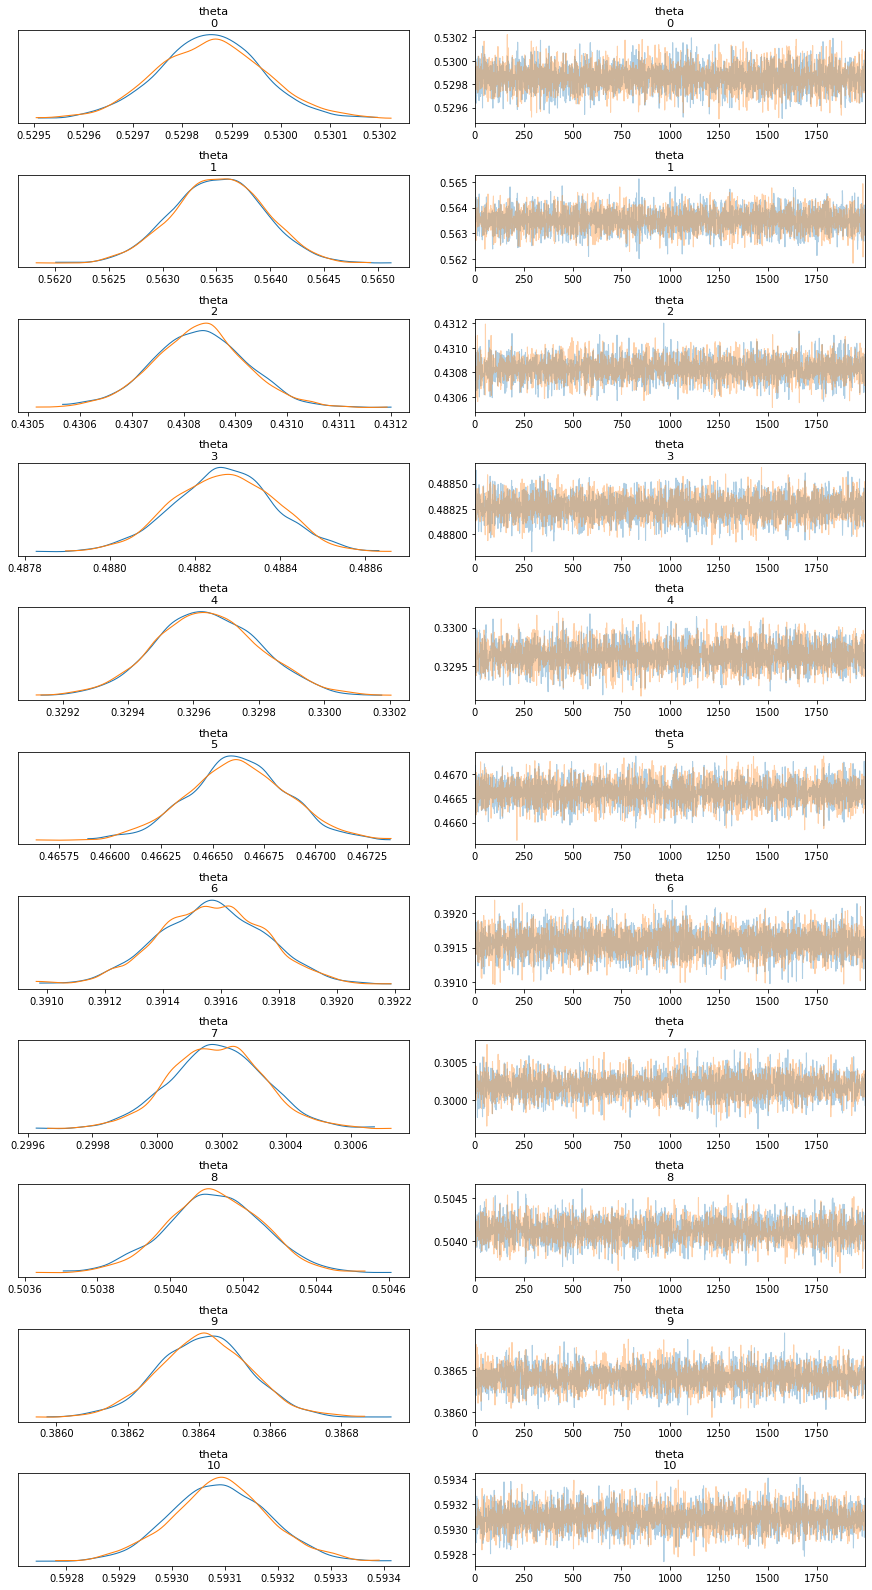

In [63]:
az.plot_trace(trace, var_names=["theta"]);

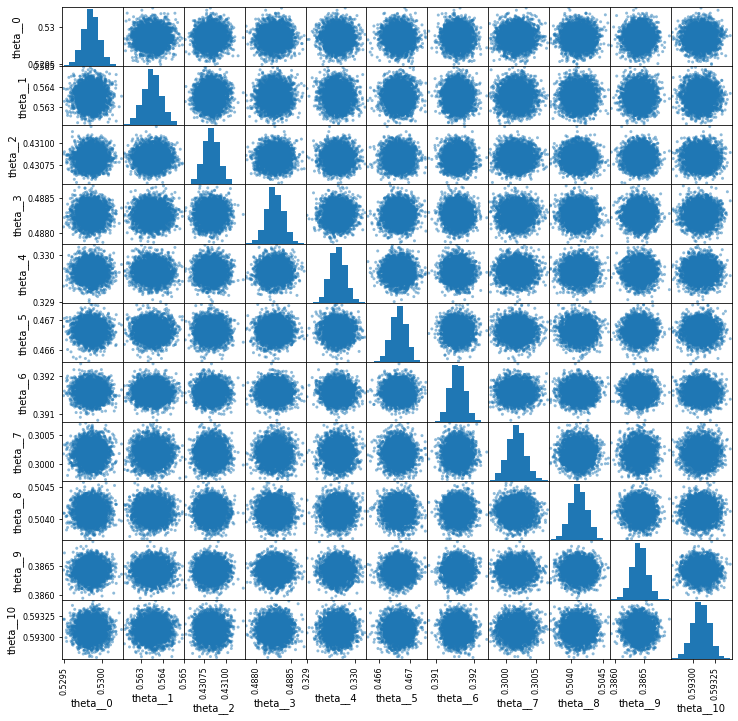

In [36]:
# Check the Scatter Matrix for any correlations or divergences.
scatter_matrix(trace_to_dataframe(trace), figsize=(12, 12));

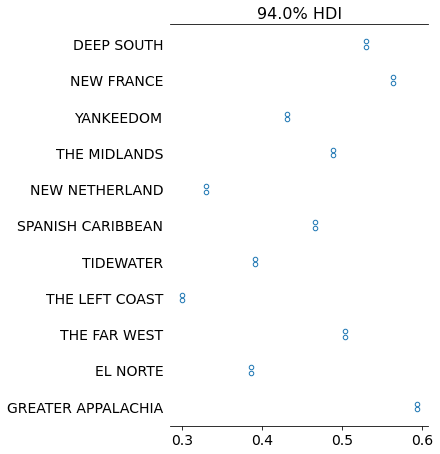

In [60]:
ax = az.plot_forest(trace, var_names=["theta"])
ax[0].set_yticklabels(rgn_names);

## Simple Bayesian Model Estimating One Parameter: Compare Years

Use the cultural regions to estimate the coefficients alone for presidential elections between 2000 - 2020.  This will allow us to compare the theta's between different years.

In [109]:
n_regions = len(rgn_names)
out_rows, traces = [], []

for year in range(2000, 2024, 4):
    print('Analyzing %i' % year)
    # Get the filtered dataframe for the year and the region index
    df_comp = filterResults(df_agg, 'President', year, 'republican')
    rgn_names = df_comp[['DESCRIPTION','REGION']].drop_duplicates().sort_values(by = 'REGION', ascending = False)['DESCRIPTION'].tolist()
    rgn_idx = df_comp['REGION'].values.astype(int) - 1

    # Define the new model and get the trace.
    with pm.Model() as model:
    # Set priors as a Beta distribution with a common a=2, b=2 shape.
        theta = pm.Beta('theta', alpha = 2, beta = 2, shape = n_regions)
        y = pm.Binomial('y',n = df_comp['totalvotes'], p = theta[rgn_idx], observed = df_comp['candidatevotes'])

        # calculate the trace with 2000 steps
        trace = pm.sample(2000, step = pm.NUTS())
    
    # Get the mean results from the region and append to a dataframe to allow year compare
    df_results = az.summary(trace)[['mean']].reset_index(drop = True)
    
    # Get the mean value from all counties to center the thetas
    theta_mean = np.mean([thetas.loc[ix].values[0] for ix in rgn_idx])
    out = {'year': year}
    for ix, row in df_results.iterrows():
        out[rgn_names[ix]] = row['mean'] - theta_mean
    
    # Append to the dataframe and check the next rows
    out_rows.append(out)
    traces.append(trace)

df_rgn_compare = pd.DataFrame(out_rows)

Analyzing 2000


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.


Analyzing 2004


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.


Analyzing 2008


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 14 seconds.


Analyzing 2012


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.


Analyzing 2016


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


Analyzing 2020


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.


In [110]:
df_rgn_compare

,year,GREATER APPALACHIA,EL NORTE,THE FAR WEST,THE LEFT COAST,TIDEWATER,SPANISH CARIBBEAN,NEW NETHERLAND,THE MIDLANDS,YANKEEDOM,NEW FRANCE,DEEP SOUTH
0,2000,0.028314,0.002314,-0.084686,-0.026686,-0.189686,-0.080686,-0.038686,-0.139686,0.052314,-0.063686,0.067314
1,2004,0.056316,0.039316,-0.063684,0.000316,-0.142684,-0.056684,-0.029684,-0.135684,0.075316,-0.026684,0.099316
2,2008,0.015316,0.064316,-0.111684,-0.054684,-0.174684,-0.086684,-0.102684,-0.193684,-0.002684,-0.094684,0.061316
3,2012,0.024316,0.055316,-0.097684,-0.034684,-0.199684,-0.083684,-0.100684,-0.186684,0.023316,-0.092684,0.088316
4,2016,0.019316,0.051316,-0.082684,-0.020684,-0.197684,-0.092684,-0.128684,-0.228684,-0.026684,-0.151684,0.089316
5,2020,0.020318,0.054318,-0.078682,-0.021682,-0.179682,-0.042682,-0.117682,-0.209682,-0.005682,-0.123682,0.083318


In [ ]:
from pymc3 import * 
import theano.tensor as T
basic_model = Model()

def logistic(l):
    return 1 / (1 + T.exp(-l))

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=18)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2 + beta[2]*X3

    # Likelihood (sampling distribution) of observations
    Y_obs = Bernoulli('Y_obs', p=logistic(mu), observed=Y)